## Data Processing

C:\Users\jihad\AppData\Local\Temp\ipykernel_15036\3381136634.py:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='2013-01-01', end='2013-12-31 23:59:00', freq='T')
C:\Users\jihad\AppData\Local\Temp\ipykernel_15036\3381136634.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Munich_weather_12h_mean = Munich_weather_1min_full.resample('12H').mean()


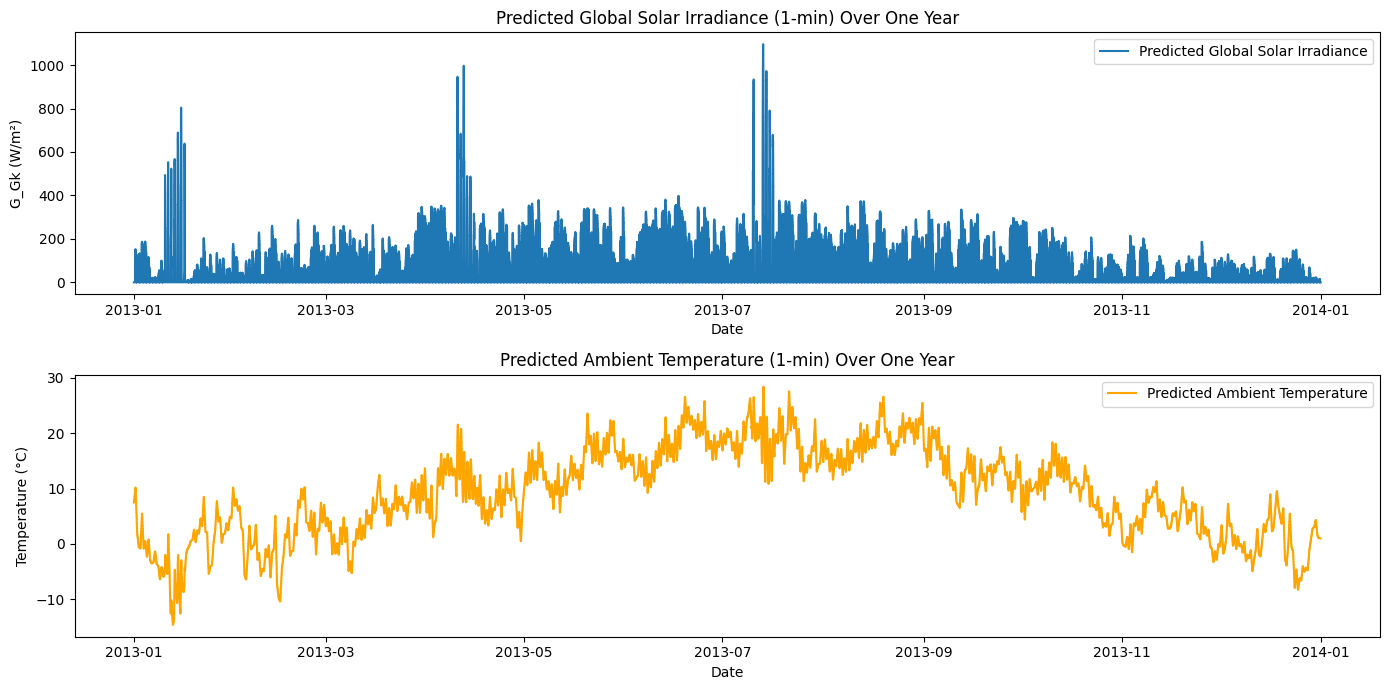

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.interpolate import PchipInterpolator
import gc

# Set flag to choose data stage
use_stage_b_data = True  # Set to True to use Stage B data, False to use Stage A data

# Load the provided data files for Stage A
hh_demand_true_A = pd.read_csv('hh_demand_true_A.csv')
Munich_weather_1min = pd.read_csv('Munich_weather_1min.csv')
Munich_weather_12h = pd.read_csv('Munich_weather_12h.csv')
dataA_params = pd.read_csv('DataA_params.csv', delimiter=';')

# Extract parameters for Stage A
params_A = {row['Parameter']: float(row['Value']) for _, row in dataA_params.iterrows()}
params_A['c_M_PV'] = params_A.pop('c_MPV')  # Correct the parameter name

# Constants for Stage A
alpha_A, beta_A, gamma_A = params_A['alpha'], params_A['beta'], params_A['gamma']
eta_B_A, eta_ref_A, c_B_A, c_M_PV_A = params_A['eta_B'], params_A['eta_ref'], params_A['c_B'], params_A['c_M_PV']
c_PV_A, G_ref_A, h_A, i_INV_A, p_EL_A, p_FI_A, T_cref_A = params_A['c_PV'], params_A['G_ref'], params_A['h'], params_A['i_INV'], params_A['p_EL'], params_A['p_FI'], params_A['T_cref']

# Prepare the weather data for Stage A
Munich_weather_1min['Timestamp'] = pd.to_datetime(Munich_weather_1min['Unnamed: 0'])
Munich_weather_1min.set_index('Timestamp', inplace=True)
Munich_weather_1min.drop(columns=['Unnamed: 0'], inplace=True)

time_range = pd.date_range(start='2013-01-01', end='2013-12-31 23:59:00', freq='T')
Munich_weather_12h['Timestamp'] = time_range[::720]  # Every 12 hours
Munich_weather_12h.set_index('Timestamp', inplace=True)
Munich_weather_12h.drop(columns=['Unnamed: 0'], inplace=True)

# Interpolation for Stage A
Munich_weather_1min_full = Munich_weather_12h.reindex(time_range).interpolate(method='linear')

# Replace the 3 weeks with the actual 1-minute data provided for Stage A
actual_data_periods = Munich_weather_1min.index
for period in actual_data_periods:
    Munich_weather_1min_full.loc[period] = Munich_weather_1min.loc[period]

# Free up memory for Stage A
del Munich_weather_12h
gc.collect()

# Add seasonal information for Stage A
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'winter'
    elif date.month in [3, 4, 5]:
        return 'spring'
    elif date.month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

Munich_weather_1min_full['Season'] = Munich_weather_1min_full.index.to_series().apply(get_season)
Munich_weather_1min_full = pd.get_dummies(Munich_weather_1min_full, columns=['Season'])
Munich_weather_1min_full['Hour'] = Munich_weather_1min_full.index.hour
Munich_weather_1min_full['Day'] = Munich_weather_1min_full.index.dayofyear
Munich_weather_1min_full['Day_of_week'] = Munich_weather_1min_full.index.dayofweek

# Adding mean of 12-hour data for Stage A
Munich_weather_12h_mean = Munich_weather_1min_full.resample('12H').mean()
Munich_weather_12h_mean = Munich_weather_12h_mean.reindex(time_range, method='nearest')
Munich_weather_1min_full['G_Gk_12h_mean'] = Munich_weather_12h_mean['G_Gk']
Munich_weather_1min_full['Ta_12h_mean'] = Munich_weather_12h_mean['Ta']

# Drop NaN values created by lagging for Stage A
Munich_weather_1min_full.dropna(inplace=True)

# Prepare the data for the ML model for Stage A
feature_columns = ['Hour', 'Day', 'Season_autumn', 'Season_spring', 'Season_summer', 'Season_winter', 
                   'Day_of_week', 'G_Gk_12h_mean', 'Ta_12h_mean']

X_A = Munich_weather_1min_full[feature_columns]
y_G_A = Munich_weather_1min_full['G_Gk']
y_T_A = Munich_weather_1min_full['Ta']

# Split the data into training and testing sets for Stage A
X_train_A, X_test_A, y_G_train_A, y_G_test_A = train_test_split(X_A, y_G_A, test_size=0.2, random_state=42)
X_train_rf_A, X_test_rf_A, y_T_train_A, y_T_test_A = train_test_split(X_A, y_T_A, test_size=0.2, random_state=42)

# Train the Random Forest model for Stage A
rf_g_A = RandomForestRegressor(n_estimators=100, random_state=42)
rf_g_A.fit(X_train_A, y_G_train_A)
rf_t_A = RandomForestRegressor(n_estimators=100, random_state=42)
rf_t_A.fit(X_train_rf_A, y_T_train_A)

# Predict the full year data with Random Forest for Stage A
Munich_weather_1min_full['G_Gk_pred'] = rf_g_A.predict(X_A)
Munich_weather_1min_full['Ta_pred'] = rf_t_A.predict(X_A)

# Identify nighttime hours based on actual data (irradiance = 0) for Stage A
night_hours_actual = Munich_weather_1min[Munich_weather_1min['G_Gk'] == 0].index.time
night_hours_set = set(night_hours_actual)

# Apply nighttime hours to predicted data for Stage A
for index, row in Munich_weather_1min_full.iterrows():
    if index.time() in night_hours_set:
        Munich_weather_1min_full.at[index, 'G_Gk_pred'] = 0

# Ensure the merged data is aligned correctly for Stage A
merged_data = hh_demand_true_A.copy()
merged_data = merged_data.iloc[:len(Munich_weather_1min_full)]  # Align the lengths
merged_data['G_Gk'] = Munich_weather_1min_full['G_Gk_pred'].values
merged_data['Ta'] = Munich_weather_1min_full['Ta_pred'].values

# Free up memory for Stage A
del hh_demand_true_A, Munich_weather_1min, Munich_weather_1min_full
gc.collect()

# Stage B Data Handling
if use_stage_b_data:
    # Load the provided data files for Stage B
    Munich_Load_1min = pd.read_csv('hh_demand_1min_B.csv')
    Munich_Load_12h = pd.read_csv('hh_demand_12h_B.csv')
    dataB_params = pd.read_csv('DataB_params.csv', delimiter=';')

    # Extract parameters for Stage B
    params_B = {row['Parameter']: float(row['Value']) for _, row in dataB_params.iterrows()}
    params_B['c_M_PV'] = params_B.pop('c_MPV')  # Correct the parameter name

    # Constants for Stage B
    alpha_B, beta_B, gamma_B = params_B['alpha'], params_B['beta'], params_B['gamma']
    eta_B_B, eta_ref_B, c_B_B, c_M_PV_B = params_B['eta_B'], params_B['eta_ref'], params_B['c_B'], params_B['c_M_PV']
    c_PV_B, G_ref_B, h_B, i_INV_B, p_EL_B, p_FI_B, T_cref_B = params_B['c_PV'], params_B['G_ref'], params_B['h'], params_B['i_INV'], params_B['p_EL'], params_B['p_FI'], params_B['T_cref']

    # Prepare the load data for Stage B
    Munich_Load_1min['Timestamp'] = pd.to_datetime(Munich_Load_1min['Unnamed: 0'])
    Munich_Load_1min.set_index('Timestamp', inplace=True)
    Munich_Load_1min.drop(columns=['Unnamed: 0'], inplace=True)

    # Create a full 1-minute time range for Stage B
    time_range = pd.date_range(start='2013-01-01', end='2013-12-31 23:59:00', freq='T')
    Munich_Load_12h['Timestamp'] = time_range[::720]  # Every 12 hours
    Munich_Load_12h.set_index('Timestamp', inplace=True)

    # Generate 1-minute data using Pchip interpolation for Stage B
    Munich_Load_1min_full = pd.DataFrame(index=time_range, columns=Munich_Load_12h.columns)
    for column in Munich_Load_12h.columns:
        if column == 'G_Gk' or column == 'Ta':
            x = np.arange(0, len(time_range), 720)
            y = Munich_Load_12h[column].values
            new_x = np.arange(len(time_range))
            Munich_Load_1min_full[column] = pchip_interpolation(x, y, new_x)
        else:
            Munich_Load_1min_full[column] = Munich_Load_12h[column].reindex(time_range, method='nearest')

    # Replace the 3 weeks with the actual 1-minute data provided for Stage B
    actual_data_periods = Munich_Load_1min.index
    for period in actual_data_periods:
        Munich_Load_1min_full.loc[period] = Munich_Load_1min.loc[period]

    # Add seasonal information for Stage B
    Munich_Load_1min_full['Season'] = Munich_Load_1min_full.index.to_series().apply(get_season)
    Munich_Load_1min_full = pd.get_dummies(Munich_Load_1min_full, columns=['Season'])
    Munich_Load_1min_full['Hour'] = Munich_Load_1min_full.index.hour
    Munich_Load_1min_full['Day'] = Munich_Load_1min_full.index.dayofyear
    Munich_Load_1min_full['Day_of_week'] = Munich_Load_1min_full.index.dayofweek

    # Drop NaN values for Stage B
    Munich_Load_1min_full.dropna(inplace=True)

    # Prepare the data for the ML model for Stage B
    X_B = Munich_Load_1min_full[feature_columns]
    y_Load_B = Munich_Load_1min_full['Load']

    # Split the data into training and testing sets for Stage B
    X_train_B, X_test_B, y_Load_train_B, y_Load_test_B = train_test_split(X_B, y_Load_B, test_size=0.2, random_state=42)

    # Train the Random Forest model for Stage B
    rf_load_B = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_load_B.fit(X_train_B, y_Load_train_B)

    # Predict the full year data with Random Forest for Stage B
    Munich_Load_1min_full['Load_pred'] = rf_load_B.predict(X_B)

    # Merge the data for final dataset
    merged_data['Load'] = Munich_Load_1min_full['Load_pred'].values

# Plot the predicted data to check its correctness
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(time_range[:len(merged_data)], merged_data['G_Gk'], label='Predicted Global Solar Irradiance')
plt.xlabel('Date')
plt.ylabel('G_Gk (W/m²)')
plt.title('Predicted Global Solar Irradiance (1-min) Over One Year')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_range[:len(merged_data)], merged_data['Ta'], label='Predicted Ambient Temperature', color='orange')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Predicted Ambient Temperature (1-min) Over One Year')
plt.legend()

if use_stage_b_data:
    plt.subplot(3, 1, 3)
    plt.plot(time_range[:len(merged_data)], merged_data['Load'], label='Predicted Load')
    plt.xlabel('Date')
    plt.ylabel('Load (W)')
    plt.title('Predicted Load (1-min) Over One Year')
    plt.legend()

plt.tight_layout()
plt.show()


## PV Model

In [47]:
import pyomo.environ as pyo
import numpy as np

# Create a Pyomo model
model = pyo.ConcreteModel()

# Ensure all values in G_Gk_pred and Ta_pred are standard Python floats
# Set negative values to zero
G_Gk_pred = {i+1: max(0, float(v)) for i, v in enumerate(merged_data['G_Gk'])}
Ta_pred = {i+1: float(v) for i, v in enumerate(merged_data['Ta'])}

# Ensure all parameter values are standard Python floats
params = {k: float(v) for k, v in (params_B if use_stage_b_data else params_A).items()}

# Define sets
model.T = pyo.RangeSet(1, len(G_Gk_pred))  # Time periods

# Define parameters
model.alpha = pyo.Param(initialize=params['alpha'])
model.beta = pyo.Param(initialize=params['beta'])
model.gamma = pyo.Param(initialize=params['gamma'])
model.eta_ref = pyo.Param(initialize=params['eta_ref'])
model.T_cref = pyo.Param(initialize=params['T_cref'])
model.G_ref = pyo.Param(initialize=params['G_ref'])
model.h = pyo.Param(initialize=params['h'])

# Define variables
model.CAP_PV = pyo.Var(within=pyo.NonNegativeReals, initialize=1)
model.CAP_B = pyo.Var(within=pyo.NonNegativeReals, initialize=1)
model.T_c = pyo.Var(model.T, within=pyo.Reals, initialize=0)
model.A_c = pyo.Var(within=pyo.NonNegativeReals, initialize=0)
model.G_t = pyo.Var(model.T, within=pyo.NonNegativeReals)
model.T_a_t = pyo.Var(model.T, within=pyo.Reals)

# Set values for G_t and T_a_t
for t in model.T:
    model.G_t[t] = G_Gk_pred[t]
    model.T_a_t[t] = Ta_pred[t]
    model.T_c[t] = model.T_a_t[t] + model.h * model.G_t[t]

# Define expressions
def eta_PV_expression(model, t):
    G_t_val = pyo.value(model.G_t[t])
    if G_t_val > 0:
        return model.eta_ref * (1 - model.beta * (model.T_c[t] - model.T_cref) + model.gamma * pyo.log(G_t_val / model.G_ref))
    else:
        return 0
model.eta_PV = pyo.Expression(model.T, rule=eta_PV_expression)
def P_PV_exp(model, t):
    Ac= pyo.value(model.alpha**(-1)) * pyo.value(model.CAP_PV)
    G_t=pyo.value(model.G_t[t])
    eta_Pv=pyo.value(model.eta_PV[t])
    return Ac * G_t * eta_Pv / 1000
model.P_PV = pyo.Expression(model.T, rule=P_PV_exp)
# We do not define an objective function here because it will be defined in the NPV cell


## Battery Model

In [48]:
import pyomo.environ as pyo

# Assuming model is already created and necessary data is imported
model.eta_B = pyo.Param(initialize=params['eta_B'])

# Define additional variables and parameters for the battery model
model.P_B = pyo.Var(model.T, within=pyo.Reals, initialize=0)  # Battery power can be positive or negative
model.SOC = pyo.Var(model.T, within=pyo.NonNegativeReals, bounds=(0, 1), initialize=0)

# Initial state of charge
model.SOC_initial = pyo.Param(initialize=0)

# Define the household power demand P_HH based on the minute load
if use_stage_b_data:
    P_HH_dict = {i+1: v for i, v in enumerate(merged_data['Load'])}
    model.P_HH = pyo.Var(model.T, within=pyo.Reals)
    for t in model.T:
        model.P_HH[t] = P_HH_dict[t]
else:
    # If not using Stage B data, set a dummy load or any other relevant data
    model.P_HH = pyo.Param(model.T, initialize=0)  # Adjust this as needed

# Define expressions for required power
def P_req_expression(model, t):
    return model.P_HH[t] - model.P_PV[t]
model.P_req = pyo.Expression(model.T, rule=P_req_expression)

# Define P_B expression
def P_B_exp(model, t):
    if t == 1:
        SOC_prev_value = model.SOC_initial
    else:
        SOC_prev_value = pyo.value(model.SOC[t-1])
    
    P_req_value = pyo.value(model.P_req[t])
    CAP_B_value = pyo.value(model.CAP_B)
    eta_B_value = pyo.value(model.eta_B)
    
    P_charge_limit = min(CAP_B_value * 60, (1 - SOC_prev_value) * CAP_B_value * 60 / eta_B_value)
    P_discharge_limit = min(CAP_B_value * 60, SOC_prev_value * eta_B_value * CAP_B_value * 60)
    
    if P_req_value < 0:
        P_B_value = -min(P_charge_limit, -P_req_value)
    else:
        P_B_value = min(P_discharge_limit, P_req_value)
    
    # Update SOC
    if P_B_value > 0:
        SOC_value = SOC_prev_value - 1 / (eta_B_value * CAP_B_value * 60) * P_B_value
    else:
        SOC_value = SOC_prev_value - eta_B_value / (CAP_B_value * 60) * P_B_value
    
    # Ensure SOC is within bounds
    if SOC_value < 0:
        SOC_value = 0
    elif SOC_value > 1:
        SOC_value = 1
    
    model.SOC[t] = SOC_value  # Update SOC directly
    
    return P_B_value

model.P_B = pyo.Expression(model.T, rule=P_B_exp)

# Ensure SOC is within bounds
def SOC_bounds(model, t):
    return pyo.inequality(0, model.SOC[t], 1)
model.SOC_bounds = pyo.Constraint(model.T, rule=SOC_bounds)


'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.expression.IndexedExpression'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().


## NPV Calculation

In [49]:
import pyomo.environ as pyo

# Define additional parameters for costs and rates
model.c_PV = pyo.Param(initialize=params['c_PV'])
model.c_B = pyo.Param(initialize=params['c_B'])
model.c_M_PV = pyo.Param(initialize=params['c_M_PV'])
model.p_EL = pyo.Param(initialize=params['p_EL'])
model.p_FI = pyo.Param(initialize=params['p_FI'])
model.i_INV = pyo.Param(initialize=params['i_INV'])

# Define expressions for power drawn from or fed to the grid
def P_D_expression(model, t):
    return model.P_HH[t] - model.P_PV[t] - model.P_B[t]
model.P_D = pyo.Expression(model.T, rule=P_D_expression)

# Define expressions for the aggregated quantities
def E_HH_T_expression(model):
    return sum(model.P_HH[t] for t in model.T) / 60
model.E_HH_T = pyo.Expression(rule=E_HH_T_expression)

def E_D_plus_T_expression(model):
    return sum(model.P_D[t] for t in model.T if pyo.value(model.P_D[t]) > 0) / 60
model.E_D_plus_T = pyo.Expression(rule=E_D_plus_T_expression)

def E_D_minus_T_expression(model):
    return sum(-model.P_D[t] for t in model.T if pyo.value(model.P_D[t]) < 0) / 60
model.E_D_minus_T = pyo.Expression(rule=E_D_minus_T_expression)

# Define initial investments
def C_0_PV_expression(model):
    return model.c_PV * model.CAP_PV
model.C_0_PV = pyo.Expression(rule=C_0_PV_expression)

def C_0_B_expression(model):
    return model.c_B * model.CAP_B
model.C_0_B = pyo.Expression(rule=C_0_B_expression)

# Define annual revenue
def R_T_expression(model):
    return model.E_D_minus_T * model.p_FI + (model.E_HH_T - model.E_D_plus_T) * model.p_EL
model.R_T = pyo.Expression(rule=R_T_expression)

# Define NPV calculation
def NPV_expression(model):
    return -model.C_0_PV - model.C_0_B + sum((model.R_T - model.C_0_PV * model.c_M_PV) / (1 + model.i_INV)**t for t in range(1, 21))
model.NPV = pyo.Expression(rule=NPV_expression)

# Objective function to maximize NPV
model.objective = pyo.Objective(expr=model.NPV, sense=pyo.maximize)


## Solver

In [50]:
import pyomo.environ as pyo
import json

# Configure solver options
solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 10  # Set maximum number of iterations
solver.options['print_level'] = 5  # Set the level of detail in the solver output

# Solve the model
results = solver.solve(model, tee=True)

# Extract and print optimal values
optimal_CAP_PV = pyo.value(model.CAP_PV)
optimal_CAP_B = pyo.value(model.CAP_B)
optimal_NPV = pyo.value(model.NPV)

print(f"Optimal Capacity for PV (CAP_PV) in kWp: {optimal_CAP_PV}")
print(f"Optimal Capacity for Battery (CAP_B) in kWh: {optimal_CAP_B}")
print(f"Optimal Net Present Value (NPV): {optimal_NPV}")

# Display detailed iteration results
print("\nDetailed Iteration Results:")
iteration_info = results.solver.termination_condition
print(iteration_info)

# If solver provides iteration details, display them
if hasattr(results.solver, 'iterations'):
    for iter_num, iter_data in enumerate(results.solver.iterations, start=1):
        print(f"Iteration {iter_num}: {iter_data}")

# Export results to a JSON file
results_dict = {
    'name': 'Group_E',  # Replace with your actual team name
    'cap_pv': optimal_CAP_PV,
    'cap_b': optimal_CAP_B,
    'npv': optimal_NPV
}

# Specify the output file path
output_file = 'optimization_results.json'

# Write results to the JSON file
with open(output_file, 'w') as json_file:
    json.dump(results_dict, json_file, indent=4)

print(f"\nResults exported to {output_file}")

Ipopt 3.12.13: max_iter=10
print_level=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:   525600
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:   525602
                     variables with only lower bounds:        2
                variables with lower and upper bounds:   525600
                     variables with only 